# Model development notebook with GPU

## Imports

In [1]:
import pathlib
import random
import model_tools as mt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.utils import shuffle
import scipy.ndimage

random.seed(42)
print('model_tools version:', mt.__version__)
print('tensorflow version: ',tf.__version__)
print('tf datasets version: ', tfds.__version__)
print('matplotlib version:', matplotlib.__version__)
print('numpy version: ', np.__version__)
print('sklearn version:', sklearn.__version__)
print('scipy version:', scipy.__version__)

model_tools version: 1.1.1
tensorflow version:  2.0.0
tf datasets version:  1.2.0
matplotlib version: 3.1.1
numpy version:  1.17.2
sklearn version: 0.22
scipy version: 1.3.1


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
print("GPU Available: ", tf.test.is_gpu_available())
print("Eager execution enabled: ", tf.executing_eagerly())

GPU Available:  True
Eager execution enabled:  True


## Model building and summary 

In [3]:
models = ['MLP1', 'MLP2', 'lenet5', 'lenet5_tuned', 'simrad', 'simrad_tuned_a', 'simrad_tuned_b']
md={}
for m in models:
    md[m]=mt.build_model(m)
    md[m].summary()

Model: "MLP1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 420)               430500    
_________________________________________________________________
dense_2 (Dense)              (None, 300)               126300    
_________________________________________________________________
output (Dense)               (None, 10)                3010      
Total params: 559,810
Trainable params: 559,810
Non-trainable params: 0
_________________________________________________________________
Model: "MLP2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 1024)              0         
__________________________________________

## Training

In [4]:
# Common
BS=64
EPOCHS=10

In [5]:
# Data prep for MLPs
def prepare_MLP():
    x_train, x_test, x_val, y_train, y_test, y_val = mt.get_mnist(categorical=False, padding=2, flatten=False, y_float=True)
    x_train, y_train = mt.expand_dataset(x_train, y_train, 2, sigma=4.0, alpha=16.0)
    x_train, y_train = shuffle(x_train, y_train)
    return x_train, x_test, x_val, y_train, y_test, y_val
x_train, x_test, x_val, y_train, y_test, y_val = prepare_MLP()

x_train shape:  (48000, 32, 32, 1)
y_train shape:  (48000,)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples
{'count': array([4718, 5363, 4792, 4923, 4689, 4346, 4728, 5037, 4660, 4744])}


In [6]:
# Multi Layer Perceptron 1
history_mp1 = md['MLP1'].fit(x_train,y_train, batch_size=BS, epochs=EPOCHS, validation_data=(x_test, y_test))

Train on 144000 samples, validate on 10000 samples
Epoch 1/10
144000/144000 [==============================] - 8s 57us/sample - loss: 0.2313 - accuracy: 0.9284 - val_loss: 0.0851 - val_accuracy: 0.9731
Epoch 2/10
144000/144000 [==============================] - 7s 49us/sample - loss: 0.0902 - accuracy: 0.9715 - val_loss: 0.0567 - val_accuracy: 0.9805
Epoch 3/10
144000/144000 [==============================] - 6s 41us/sample - loss: 0.0596 - accuracy: 0.9809 - val_loss: 0.0570 - val_accuracy: 0.9815
Epoch 4/10
144000/144000 [==============================] - 9s 60us/sample - loss: 0.0425 - accuracy: 0.9863 - val_loss: 0.0561 - val_accuracy: 0.9835
Epoch 5/10
144000/144000 [==============================] - 8s 57us/sample - loss: 0.0323 - accuracy: 0.9896 - val_loss: 0.0550 - val_accuracy: 0.9833
Epoch 6/10
144000/144000 [==============================] - 8s 54us/sample - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.0607 - val_accuracy: 0.9816
Epoch 7/10
144000/144000 [=================

In [7]:
# Multi Layer Perceptron 2
history_mp2 = md['MLP2'].fit(x_train,y_train, batch_size=BS, epochs=EPOCHS, validation_data=(x_test, y_test))

Train on 144000 samples, validate on 10000 samples
Epoch 1/10
144000/144000 [==============================] - 7s 51us/sample - loss: 0.1753 - accuracy: 0.9466 - val_loss: 0.0931 - val_accuracy: 0.9719
Epoch 2/10
144000/144000 [==============================] - 7s 50us/sample - loss: 0.0786 - accuracy: 0.9767 - val_loss: 0.0678 - val_accuracy: 0.9812
Epoch 3/10
144000/144000 [==============================] - 8s 52us/sample - loss: 0.0609 - accuracy: 0.9833 - val_loss: 0.0590 - val_accuracy: 0.9851
Epoch 4/10
144000/144000 [==============================] - 8s 52us/sample - loss: 0.0525 - accuracy: 0.9858 - val_loss: 0.0709 - val_accuracy: 0.9847
Epoch 5/10
144000/144000 [==============================] - 8s 58us/sample - loss: 0.0467 - accuracy: 0.9883 - val_loss: 0.0772 - val_accuracy: 0.9843
Epoch 6/10
144000/144000 [==============================] - 7s 48us/sample - loss: 0.0401 - accuracy: 0.9897 - val_loss: 0.0939 - val_accuracy: 0.9842
Epoch 7/10
144000/144000 [=================

In [8]:
# Data prep for LeNet
def prepare_lenet():
    x_train, x_test, x_val, y_train, y_test, y_val = mt.get_mnist(categorical=True, padding=2, flatten=False, y_float=False)
    x_train, y_train = mt.expand_dataset(x_train, y_train, 2, sigma=4.0, alpha=16.0)
    x_train, y_train = shuffle(x_train, y_train)
    return x_train, x_test, x_val, y_train, y_test, y_val
x_train, x_test, x_val, y_train, y_test, y_val = prepare_lenet()

x_train shape:  (48000, 32, 32, 1)
y_train shape:  (48000, 1, 1, 10)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples


In [9]:
# LeNet
# Image generator
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20, zoom_range=0.15,
	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
	horizontal_flip=True, fill_mode="nearest")
# Train the network
history_lenet = md['lenet5'].fit_generator(aug.flow(x_train, y_train, batch_size=BS),
	validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.7195 - accuracy: 0.7563 - val_loss: 0.2547 - val_accuracy: 0.9127
Epoch 2/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.4117 - accuracy: 0.8653 - val_loss: 0.1831 - val_accuracy: 0.9424
Epoch 3/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.3516 - accuracy: 0.8864 - val_loss: 0.1557 - val_accuracy: 0.9495
Epoch 4/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.3204 - accuracy: 0.8973 - val_loss: 0.1503 - val_accuracy: 0.9512
Epoch 5/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.2999 - accuracy: 0.9039 - val_loss: 0.1347 - val_accuracy: 0.9572
Epoch 6/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.2858 - accuracy: 0.9090 - val_loss: 0.1310 - val_accuracy: 0.9586
Epoch 7/10
2250/2250 [==============================] - 55s 24ms/step - loss: 0.2744 - accuracy: 0.9119 - val_loss: 0.1170 -

In [10]:
# LeNet tuned
history_lenet_tuned = md['lenet5_tuned'].fit_generator(aug.flow(x_train, y_train, batch_size=BS),
	validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.5397 - accuracy: 0.8193 - val_loss: 0.1343 - val_accuracy: 0.9575
Epoch 2/10
2250/2250 [==============================] - 55s 24ms/step - loss: 0.2762 - accuracy: 0.9118 - val_loss: 0.1207 - val_accuracy: 0.9607
Epoch 3/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.2334 - accuracy: 0.9253 - val_loss: 0.0878 - val_accuracy: 0.9720
Epoch 4/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.2082 - accuracy: 0.9336 - val_loss: 0.1010 - val_accuracy: 0.9683
Epoch 5/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.1960 - accuracy: 0.9370 - val_loss: 0.0923 - val_accuracy: 0.9718
Epoch 6/10
2250/2250 [==============================] - 55s 25ms/step - loss: 0.1832 - accuracy: 0.9413 - val_loss: 0.0798 - val_accuracy: 0.9746
Epoch 7/10
2250/2250 [==============================] - 56s 25ms/step - loss: 0.1780 - accuracy: 0.9433 - val_loss: 0.0768 -

In [11]:
# Data prep for Simrad
def prepare_simrad():
    x_train_crop, x_test_crop, x_val_crop, y_train, y_test, y_val = mt.ecc()
    x_train_crop, y_train_crop = mt.expand_dataset(x_train_crop, y_train, 2, sigma=4.0, alpha=16.0, sizex=29, sizey=29)
    x_train_crop, y_train_crop = shuffle(x_train_crop, y_train_crop)
    y_train_crop=y_train_crop.reshape(y_train_crop.shape[0],10)
    y_test=y_test.reshape(y_test.shape[0],10)
    return x_train_crop, x_test_crop, x_val_crop, y_train_crop, y_test, y_val
x_train_crop, x_test_crop, x_val_crop, y_train_crop, y_test, y_val = prepare_simrad()

x_train shape:  (48000, 28, 28, 1)
y_train shape:  (48000, 1, 1, 10)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples


In [12]:
# Simrad
history_simrad = md['simrad'].fit_generator(aug.flow(x_train_crop, y_train_crop, batch_size=BS),
	validation_data=(x_test_crop, y_test), steps_per_epoch=len(x_train_crop) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.9645 - accuracy: 0.6720 - val_loss: 0.3171 - val_accuracy: 0.8952
Epoch 2/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.5404 - accuracy: 0.8242 - val_loss: 0.2797 - val_accuracy: 0.9057
Epoch 3/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4611 - accuracy: 0.8519 - val_loss: 0.2127 - val_accuracy: 0.9296
Epoch 4/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4186 - accuracy: 0.8655 - val_loss: 0.1868 - val_accuracy: 0.9388
Epoch 5/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3934 - accuracy: 0.8750 - val_loss: 0.1682 - val_accuracy: 0.9461
Epoch 6/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3706 - accuracy: 0.8828 - val_loss: 0.1653 - val_accuracy: 0.9448
Epoch 7/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3583 - accuracy: 0.8860 - val_loss: 0.1537 -

In [13]:
# Simrad tuned variation A
history_simrad_tuned_a = md['simrad_tuned_a'].fit_generator(aug.flow(x_train_crop, y_train_crop, batch_size=BS),
	validation_data=(x_test_crop, y_test), steps_per_epoch=len(x_train_crop) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.9596 - accuracy: 0.6745 - val_loss: 0.3354 - val_accuracy: 0.8850
Epoch 2/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.5112 - accuracy: 0.8352 - val_loss: 0.2356 - val_accuracy: 0.9198
Epoch 3/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4266 - accuracy: 0.8635 - val_loss: 0.1964 - val_accuracy: 0.9359
Epoch 4/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3868 - accuracy: 0.8774 - val_loss: 0.1652 - val_accuracy: 0.9449
Epoch 5/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3584 - accuracy: 0.8873 - val_loss: 0.1365 - val_accuracy: 0.9533
Epoch 6/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.3397 - accuracy: 0.8920 - val_loss: 0.1370 - val_accuracy: 0.9527
Epoch 7/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3239 - accuracy: 0.8974 - val_loss: 0.1225 -

In [14]:
# Simrad tuned variation B
history_simrad_tuned_b = md['simrad_tuned_b'].fit_generator(aug.flow(x_train_crop, y_train_crop, batch_size=BS),
	validation_data=(x_test_crop, y_test), steps_per_epoch=len(x_train_crop) // BS,
	epochs=EPOCHS)

Epoch 1/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.9388 - accuracy: 0.6826 - val_loss: 0.3307 - val_accuracy: 0.8869
Epoch 2/10
2250/2250 [==============================] - 41s 18ms/step - loss: 0.5080 - accuracy: 0.8372 - val_loss: 0.2284 - val_accuracy: 0.9234
Epoch 3/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.4247 - accuracy: 0.8647 - val_loss: 0.1781 - val_accuracy: 0.9429
Epoch 4/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3832 - accuracy: 0.8803 - val_loss: 0.1606 - val_accuracy: 0.9466
Epoch 5/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3552 - accuracy: 0.8883 - val_loss: 0.1537 - val_accuracy: 0.9507
Epoch 6/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3390 - accuracy: 0.8936 - val_loss: 0.1379 - val_accuracy: 0.9536
Epoch 7/10
2250/2250 [==============================] - 40s 18ms/step - loss: 0.3242 - accuracy: 0.8972 - val_loss: 0.1358 -

## Metrics

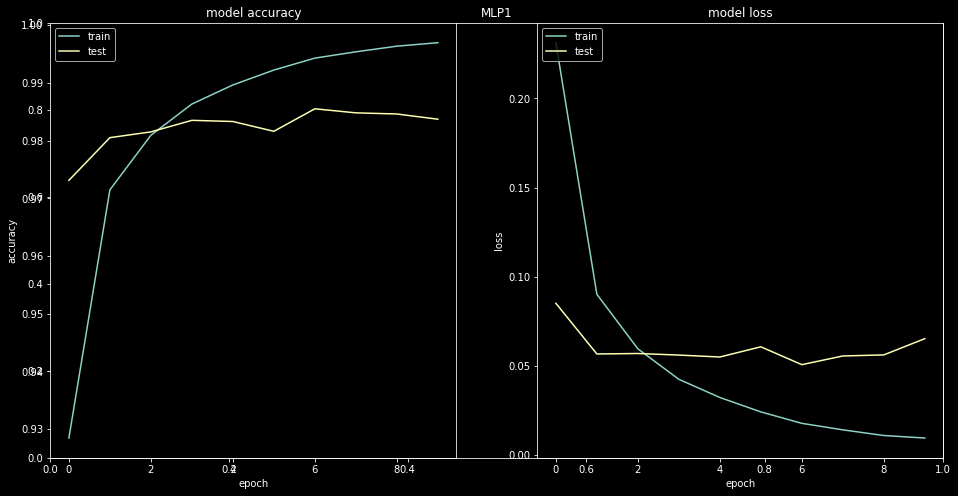

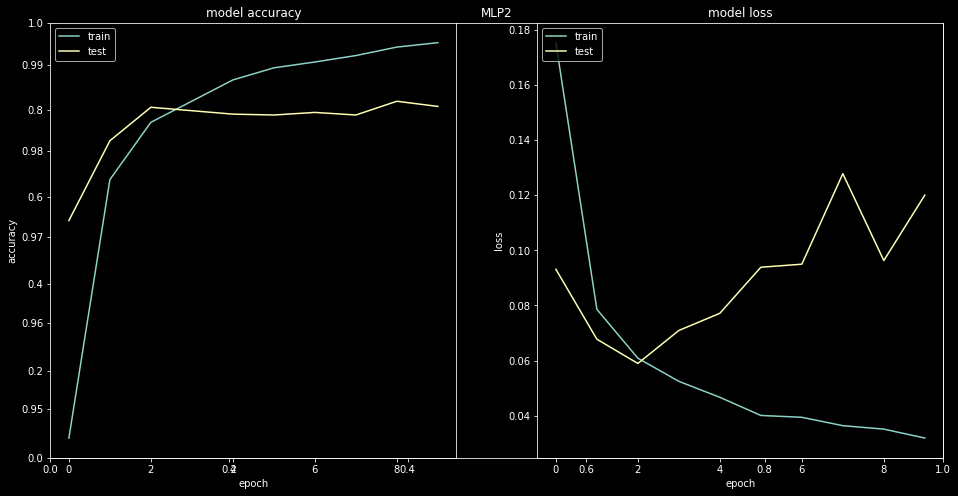

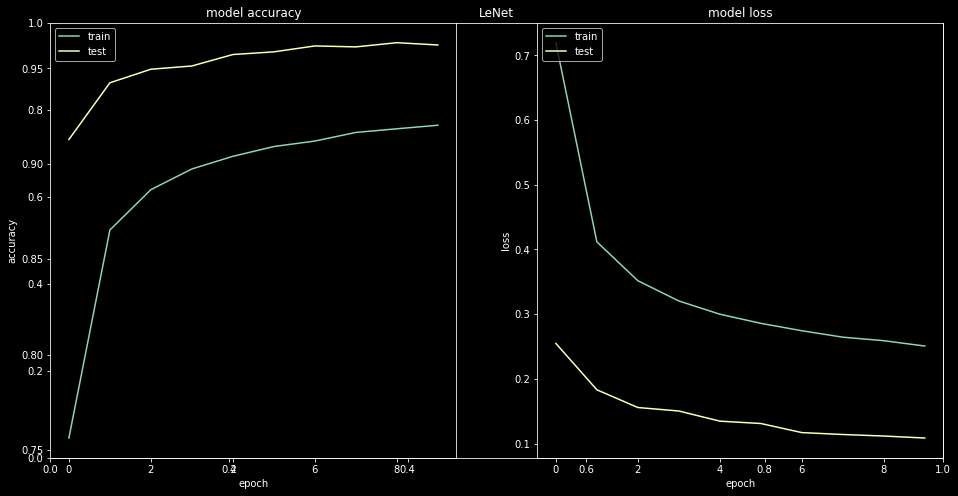

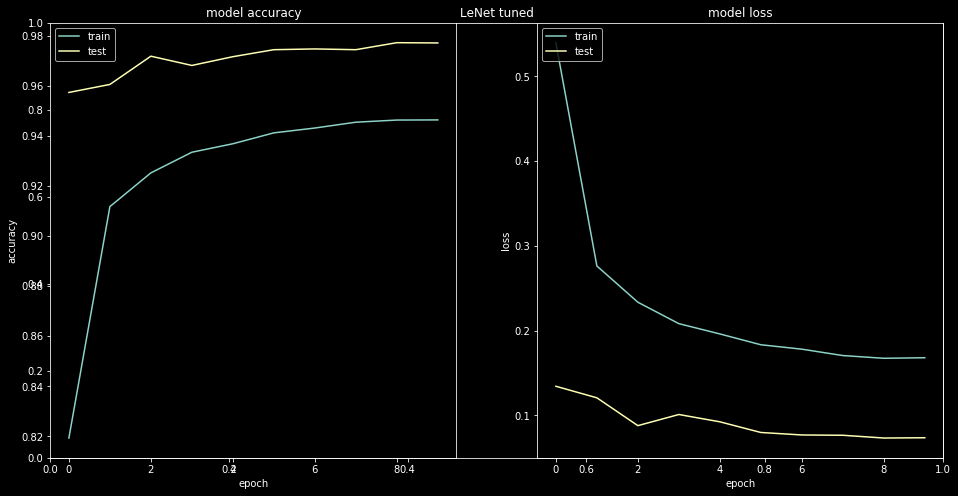

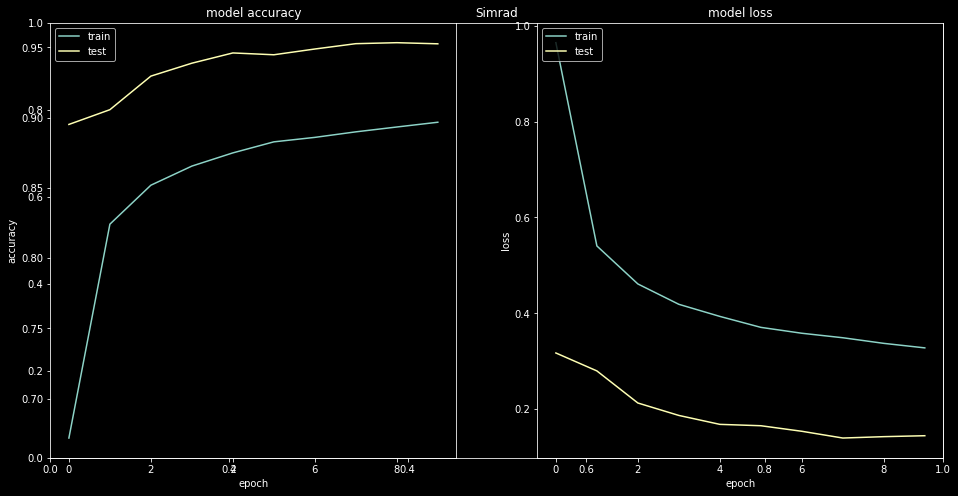

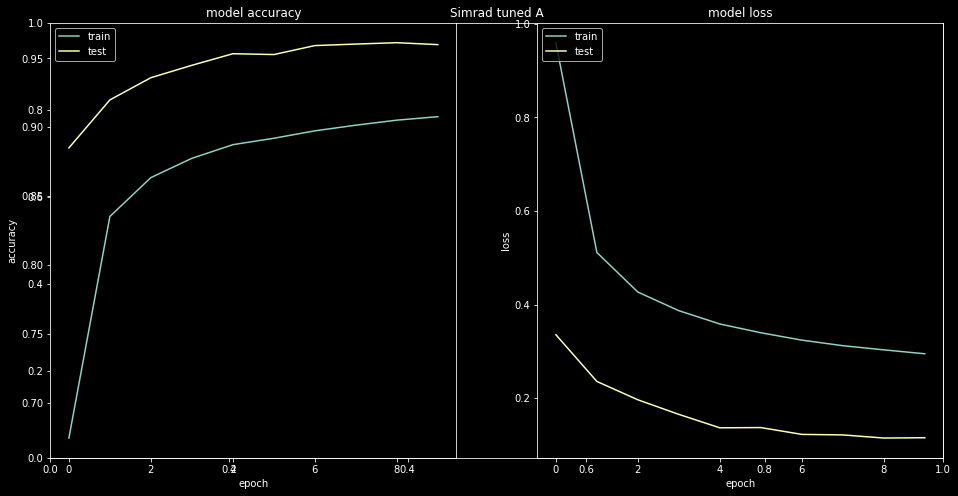

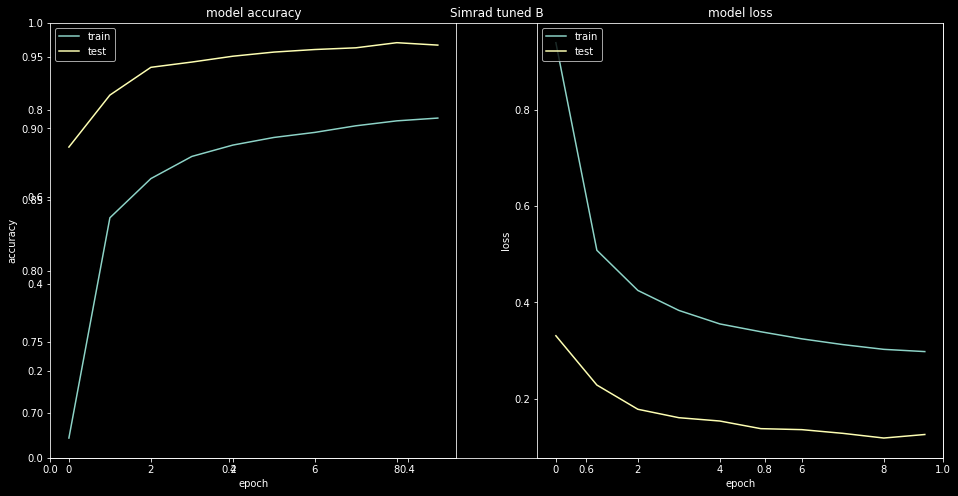

In [15]:
mt.plot_history(history_mp1, 'MLP1')
mt.plot_history(history_mp2, 'MLP2')
mt.plot_history(history_lenet, 'LeNet')
mt.plot_history(history_lenet_tuned, 'LeNet tuned')
mt.plot_history(history_simrad, 'Simrad')
mt.plot_history(history_simrad_tuned_a, 'Simrad tuned A')
mt.plot_history(history_simrad_tuned_b, 'Simrad tuned B')

## Save models

In [17]:
import os
from pathlib import Path
path = pathlib.Path('.')
path = path / 'model_dev_dir'
if not os.path.exists(path):
    path.mkdir()
print(path.resolve())
for m in models:
    k =  path / m
    if not os.path.exists(k):
        k.mkdir()
    md[m].save(str(k / (m + '.h5')))

/home/luismata/git/ai_tools/python/models_dev/model_dev_dir


## Save data

In [18]:
path = pathlib.Path('./model_dev_dir/_data')
if not os.path.exists(path):
    path.mkdir()
# MLPs
k =  path / 'MLPs'
x_train, x_test, x_val, y_train, y_test, y_val = prepare_MLP()
mt.save_data_to_file(k, x_train, y_train, x_test, y_test)
# Lenets
k = path / 'lenets'
x_train, x_test, x_val, y_train, y_test, y_val = prepare_lenet()
mt.save_data_to_file(k, x_train, y_train, x_test, y_test)
# Simrads
k = path / 'simrads'
x_train, x_test, x_val, y_train, y_test, y_val = prepare_simrad()
mt.save_data_to_file(k, x_train, y_train, x_test, y_test)

x_train shape:  (48000, 32, 32, 1)
y_train shape:  (48000,)
x_train type:  <class 'numpy.ndarray'>
48000 train samples
10000 test samples
12000 validation samples
{'count': array([4718, 5363, 4792, 4923, 4689, 4346, 4728, 5037, 4660, 4744])}


NameError: name 'save_data_to_file' is not defined